In [1]:
from visualize import *

<AxesSubplot:>

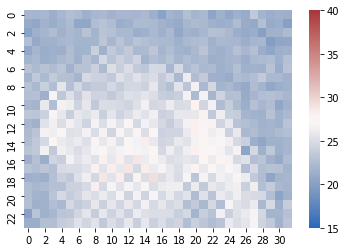

In [26]:
sns.heatmap(data[152,:,:,11] , cmap="vlag" , vmin=15 ,vmax=40)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import scipy.stats as sc

In [2]:
def gaussian_pdf(x , sigma , mu):
    pdf1 = (1/(sigma*np.sqrt(2*np.pi)))
    pdf2 = np.exp(-0.5*((x-mu)/sigma)**2)
    return pdf1*pdf2
n = 0.01
mean = np.zeros((235,24,32,16))
mean[0,:,:,0] = np.copy(data[0,:,:,0])
sigma = 0.4
alpha = 0.0001
M = 0
gmean = np.zeros((235,24,32,16))
gp = np.zeros((235,24,32,16))
event = np.zeros((235,24,32,16))

for i in range(0,1):
    for j in range(0,1):
        for k in range(0,24):
            for l in range(0,32):
                event[i,k,l,j] = 1

for j in range(0,16):
    mean[0,:,:,0] = mean[0,:,:,0] + data[0,:,:,j]
for j in range(0,9):
    mean[0,:,:,0] = mean[0,:,:,0] + data[1,:,:,j]

mean[0,:,:,0] = mean[0,:,:,0]/25

fg = []
cnt = np.zeros((236,16))
bg = []
maxi = np.zeros((235,24,32,16))
mini = np.zeros((235,24,32,16))
mini[0,:,:,0] = data[0,:,:,0]
maxi[0,:,:,0] = data[0,:,:,0]
theta = 0.015
gamma = 0.2

In [3]:

for l in range(0,235):
    start = 0
    if l == 0:
        start = 1
    for k in range(start,16):
        for i in range(0,24):
            for j in range(0,32):
                if k==0:
                    mean[l,i,j,k] = alpha*data[l,i,j,k] + mean[l-1,i,j,15]*(1-alpha)        ## Mean if k==0 and l!=0
                    maxi[l,i,j,k] = max(maxi[l-1,i,j,15] , data[l,i,j,k])
                    mini[l,i,j,k] = min(mini[l-1,i,j,15] , data[l,i,j,k])
                else:
                    mean[l,i,j,k] = alpha*data[l,i,j,k] + mean[l,i,j,k-1]*(1-alpha)                  ## Mean if k!=0 and l!=0
                    maxi[l,i,j,k] = max(maxi[l,i,j,k-1] , data[l,i,j,k])
                    mini[l,i,j,k] = min(mini[l,i,j,k-1] , data[l,i,j,k])

                gp[l,i,j,k] = gaussian_pdf(data[l,i,j,k] , sigma , mean[l,i,j,k])                    ## Find the gaussian PDF 
                if gp[l,i,j,k]<n and data[l,i,j,k]>mean[0,i,j,0]:                                   ## Process is foreground
                    event[l,i,j,k] = 0
                    fg.append((data[l,i,j,k] , mean[l,i,j,k]))
                    if k!=0:
                        mean[l,i,j,k] = mean[l,i,j,k-1]                                       ## Update the mean if the process is foreground
                    else:
                        mean[l,i,j,k] = mean[l-1,i,j,15]

                else:
                    event[l,i,j,k] = 1   
                    bg.append((data[l,i,j,k] , mean[l,i,j,k]))                              ## Process is Background

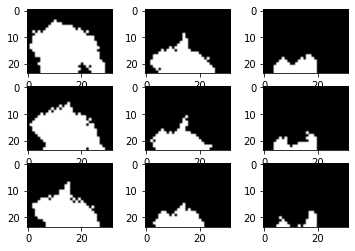

In [24]:
fig, axs = plt.subplots(3, 3)
axs[0,0].imshow(mrf_event[152,:,:,11] , cmap='Greys')
axs[1,0].imshow(mrf_event[152,:,:,12] , cmap='Greys')
axs[2,0].imshow(mrf_event[152,:,:,13] , cmap='Greys')
axs[0,1].imshow(mrf_event[152,:,:,14] , cmap='Greys')
axs[1,1].imshow(mrf_event[152,:,:,15] , cmap='Greys')
axs[2,1].imshow(mrf_event[153,:,:,0] , cmap='Greys')
axs[0,2].imshow(mrf_event[153,:,:,1] , cmap='Greys')
axs[1,2].imshow(mrf_event[153,:,:,2] , cmap='Greys')
axs[2,2].imshow(mrf_event[153,:,:,3] , cmap='Greys')

In [4]:
diff = np.zeros((235,24,32,16))
mrf_event = np.zeros((235,24,32,16))
mrf_event[0,:,:,0] = 1
for l in range(0,235):
    for k in range(0,16):
        for i in range(0,24):
            for j in range(0,32):
                qf = 0
                qb = 0
                ratio = gp[l,i,j,k]*25
                if i>0 and j>0:
                    if event[l,i-1,j-1,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1
                if i>0:
                    if event[l,i-1,j,k] == 0:
                        qf = qf+1
                    else:
                        qb = qb+1
                if j<31 and i>0:
                    if event[l,i-1,j+1,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1
                if j>0:
                    if event[l,i,j-1,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1
                if j<31:
                    if event[l,i,j+1,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1
                if i<23 and j>0:
                    if event[l,i+1,j-1,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1
                if i<23:
                    if event[l,i+1,j,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1
                if i<23 and j<31:
                    if event[l,i+1,j+1,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1

                mrf = theta * np.exp((qf-qb)/gamma)
                if ratio < mrf and data[l,i,j,k] > mean[l,i,j,k] and data[l,i,j,k] > mean[0,i,j,0]:
                    mrf_event[l,i,j,k] = 0
                    cnt[l,k] = cnt[l,k] + 1
                else:
                    mrf_event[l,i,j,k] = 1
                diff[l,i,j,k] = ratio-mrf


In [5]:
for l in range(0,235):
    for k in range(0,16):
        if cnt[l,k] > 100:
            print(l,k)


14 9
14 10
14 11
14 12
14 13
14 14
14 15
15 0
15 1
15 2
15 3
15 4
15 5
109 8
109 9
109 10
109 11
109 12
109 13
109 14
109 15
110 0
110 1
110 2
152 2
152 3
152 4
152 5
152 6
152 7
152 8
152 9
152 10
152 11
152 12
152 13
152 14
152 15
170 14
170 15
171 0
171 1
171 2
171 3
171 4
171 5
171 6
171 7
171 8
171 9
171 10
171 11
171 12
171 13
171 14
171 15
172 0
172 1
172 2
172 3
172 4
172 5
172 6
172 7
172 8
172 9
172 10
172 11
172 12
172 13
172 14
172 15
173 0
173 1
173 2
173 3
173 4
173 5
173 6
173 7
173 8
173 9
173 10
173 11
173 12
173 13
173 14
173 15
174 0
174 1
174 2
174 3
174 4
174 5
174 6
174 7
174 8
174 9
174 10
174 11
174 12
174 13
174 14
174 15
175 0
175 1
175 2
175 3
175 4
175 5
175 6
175 7
175 8
175 9
175 10
175 11
175 12
175 13
175 14
175 15
176 0
176 1
176 2
176 3
176 4
176 5
176 6
178 10
178 11
178 12
178 13
178 14
178 15
179 0
179 1
179 2
179 3
179 4
179 5
179 6
179 7
179 8
179 9
179 10
179 11
179 12
179 13
179 14
179 15
180 0
180 1
180 2
180 3
180 4
180 5
180 6
180 7
180 8
180

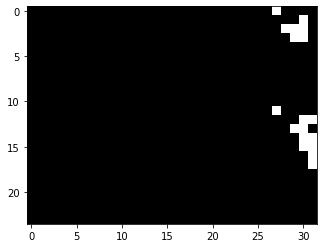

In [145]:
plt.imshow(mrf_event[142,:,:,7] , cmap='Greys')

In [123]:
gaussian_pdf(20.2 , 0.4 , 21.9)

0.005072620143249392

In [125]:
sc.norm(21.56,0.4).pdf(20.35)

0.01027583454133161